# Challenge Vodafone

En este challenge vamos a tratar de encontrar en qué ciudad había más probabilidad de lluvia, Sydney o Perth, para el día 2014-02-05.

Primero de todo, habrá que descomprimir el reto:

In [ ]:
!unzip /content/drive/MyDrive/Pruebas\ Técnicas/Vodafone/rain_australia_exercise_short.zip

Archive:  /content/drive/MyDrive/Pruebas Técnicas/Vodafone/rain_australia_exercise_short.zip
   creating: rain_australia_exercise_short/
  inflating: rain_australia_exercise_short/rain_australia_enunciado_short.docx  
  inflating: __MACOSX/rain_australia_exercise_short/._rain_australia_enunciado_short.docx  
  inflating: rain_australia_exercise_short/rain_australia_dataset.csv  
  inflating: __MACOSX/rain_australia_exercise_short/._rain_australia_dataset.csv  


Cargamos las librerías que utilizaremos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, OrdinalEncoder
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel, RFECV
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from sklearn.decomposition import TruncatedSVD
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Configuramos la visualización de los datos
pd.set_option('max_columns', False)

## Data Exploration

Vamos a leer los datos:

In [3]:
# Leemos los datos
#df = pd.read_csv(r'/content/rain_australia_exercise_short/rain_australia_dataset.csv')
df = pd.read_csv(r'https://raw.githubusercontent.com/JoelDela/TFM-Master_Data_Science_Kschool/master/rain_australia_dataset.csv')
# Vamos a tirar posibles duplicados
df = df.drop_duplicates()

# Vamos a pasar a binario las columnas de lluvia:
df['RainToday'] = np.where(df['RainToday']=="Yes",1,0)
df['RainTomorrow'] = np.where(df['RainTomorrow']=="Yes",1,0)

# Pasamos la columna Date a fecha
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')

# Cogemos la columna Date y sacamos el mes, la semana del año y el día:
df['Month'] = df.Date.dt.month
df['Day'] = df.Date.dt.day
df['Week'] = df.Date.dt.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Tras leer los datos, vamos a echarle un vistazo:

In [ ]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Alg3pm,Alg9am,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,PXW,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Day,Week
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,0.801549,1.045641,71.0,22.0,1007.7,1007.1,8.0,NaN,12.4,16.9,21.8,0,0,12,1,49
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,0.649182,0.338796,44.0,25.0,1010.6,1007.8,NaN,NaN,12.4,17.2,24.3,0,0,12,2,49
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,0.878462,-1.506112,38.0,30.0,1007.6,1008.7,NaN,2.0,12.4,21.0,23.2,0,0,12,3,49
3,2008-12-04,Albury,139.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,0.292656,0.473577,45.0,16.0,1017.6,1012.8,NaN,NaN,12.4,18.1,26.5,0,0,12,4,49
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,0.219320,-0.160029,82.0,33.0,1010.8,1006.0,7.0,8.0,12.4,17.8,29.7,0,0,12,5,49


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 142192
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           142193 non-null  datetime64[ns]
 1   Location       142193 non-null  object        
 2   MinTemp        141552 non-null  float64       
 3   MaxTemp        141867 non-null  float64       
 4   Rainfall       140787 non-null  float64       
 5   Evaporation    81350 non-null   float64       
 6   Sunshine       74377 non-null   float64       
 7   WindGustDir    132859 non-null  object        
 8   WindGustSpeed  132919 non-null  float64       
 9   WindDir9am     132180 non-null  object        
 10  WindDir3pm     138415 non-null  object        
 11  WindSpeed9am   140845 non-null  float64       
 12  WindSpeed3pm   139563 non-null  float64       
 13  Alg3pm         142193 non-null  float64       
 14  Alg9am         142193 non-null  float64       
 15  

In [ ]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Alg3pm,Alg9am,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,PXW,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Day,Week
count,141552.000000,141867.000000,140787.000000,81350.000000,74377.000000,132919.000000,140845.000000,139563.000000,142193.000000,142193.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,1.421930e+05,141289.000000,139467.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000
mean,12.187422,23.237310,2.349974,5.469824,7.624853,39.984103,14.001988,18.637576,0.499631,0.001909,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,1.240000e+01,16.987509,21.687235,0.221213,0.224181,6.402544,15.715084,26.119007
std,6.412182,7.941855,8.465173,4.188537,3.781525,13.588649,8.893337,8.803345,0.288829,0.998886,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,2.797239e-11,6.492838,6.937594,0.415065,0.417043,3.426506,8.798150,14.980379
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000021,-4.124446,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,1.240000e+01,-7.200000,-5.400000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,0.249034,-0.674254,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,1.240000e+01,12.300000,16.600000,0.000000,0.000000,3.000000,8.000000,13.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,0.498712,0.001727,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,1.240000e+01,16.700000,21.100000,0.000000,0.000000,6.000000,16.000000,26.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,0.749886,0.675741,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,1.240000e+01,21.600000,26.400000,0.000000,0.000000,9.000000,23.000000,39.000000
max,139.200000,1333.400000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,0.999997,4.550245,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,1.240000e+01,40.200000,46.700000,1.000000,1.000000,12.000000,31.000000,53.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8348d87350>,
      dtype=object)

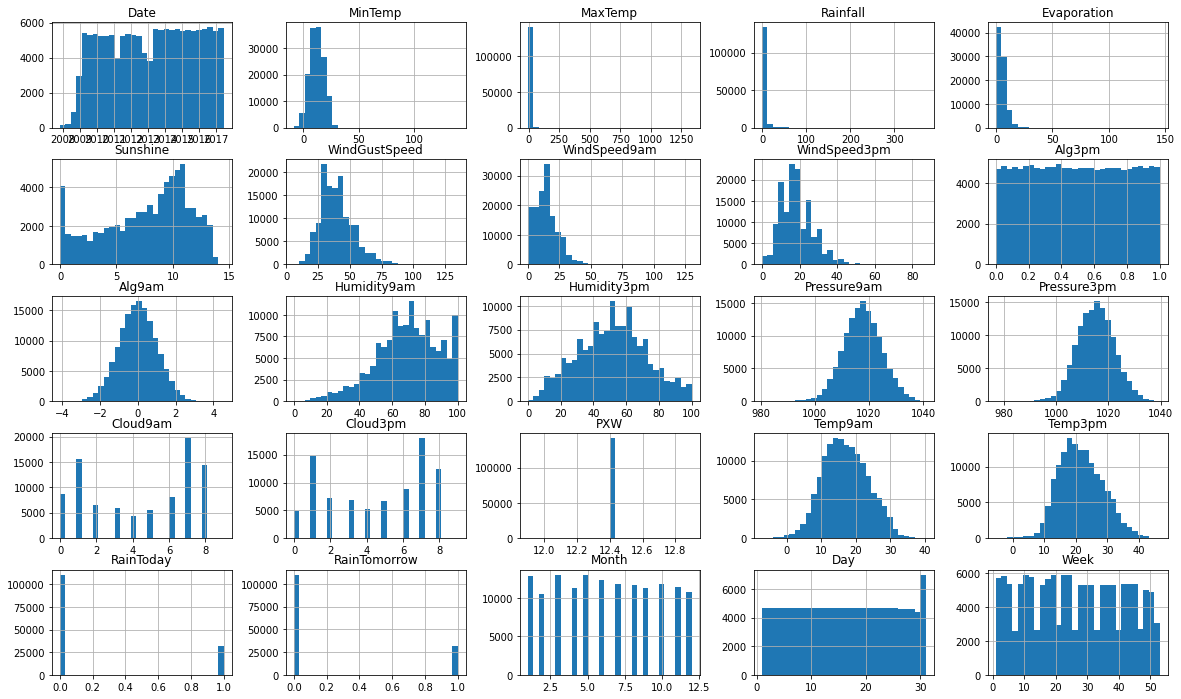

In [ ]:
df.hist(bins=30,figsize=(20,12))

Vamos a hacer scatterplot de algunas variables, a ver como se relacionan con la variable objetivo:

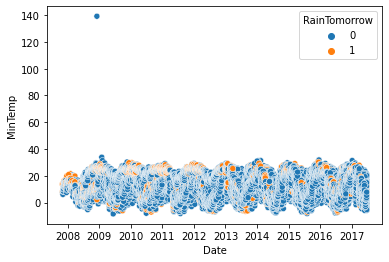

In [ ]:
sns.scatterplot(data=df,x='Date',y='MinTemp',hue='RainTomorrow')#sns.boxplot(data=df, x='Date',y='MinTemp',hue='RainTomorrow')

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


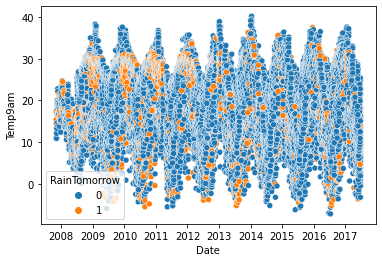

In [ ]:
sns.scatterplot(data=df,x='Date',y='Temp9am',hue='RainTomorrow')

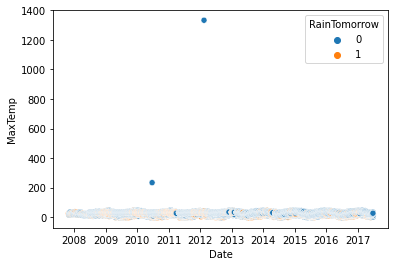

In [ ]:
sns.scatterplot(data=df,x='Date',y='MaxTemp',hue='RainTomorrow')

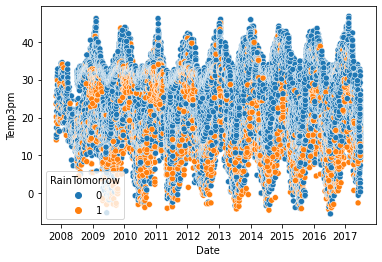

In [ ]:
sns.scatterplot(data=df,x='Date',y='Temp3pm',hue='RainTomorrow')

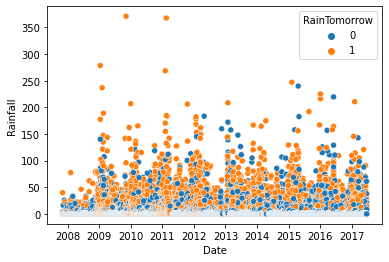

In [ ]:
sns.scatterplot(data=df,x='Date',y='Rainfall',hue='RainTomorrow')

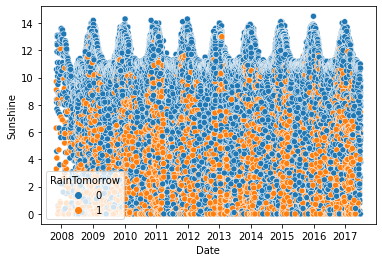

In [ ]:
sns.scatterplot(data=df,x='Date',y='Sunshine',hue='RainTomorrow')

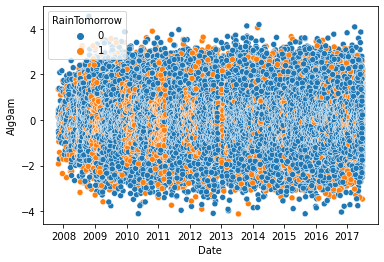

In [ ]:
sns.scatterplot(data=df,x='Date',y='Alg9am',hue='RainTomorrow')

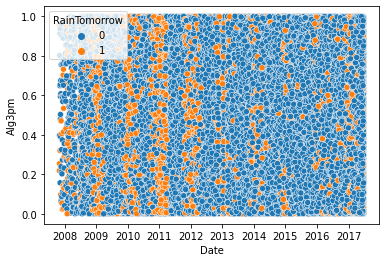

In [ ]:
sns.scatterplot(data=df,x='Date',y='Alg3pm',hue='RainTomorrow')

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


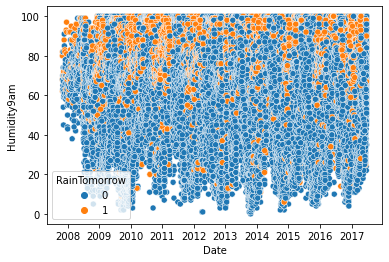

In [ ]:
sns.scatterplot(data=df,x='Date',y='Humidity9am',hue='RainTomorrow')

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


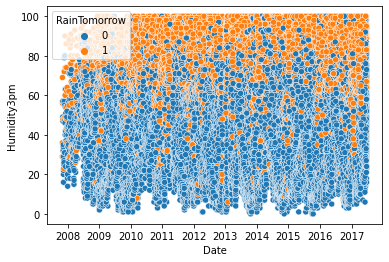

In [ ]:
sns.scatterplot(data=df,x='Date',y='Humidity3pm',hue='RainTomorrow')

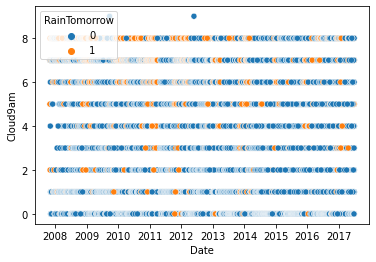

In [ ]:
sns.scatterplot(data=df,x='Date',y='Cloud9am',hue='RainTomorrow')

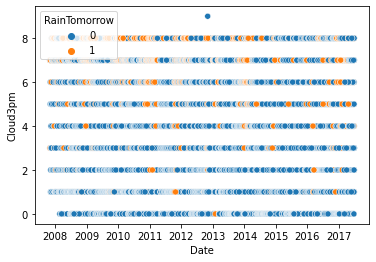

In [ ]:
sns.scatterplot(data=df,x='Date',y='Cloud3pm',hue='RainTomorrow')

In [ ]:
sns.scatterplot(data=df,x='Date',y='WindGustSpeed',hue='RainTomorrow')

In [ ]:
sns.scatterplot(data=df,x='Date',y='WindSpeed9am',hue='RainTomorrow')

In [ ]:
sns.scatterplot(data=df,x='Date',y='WindSpeed3pm',hue='RainTomorrow')

In [ ]:
sns.scatterplot(data=df,x='Date',y='Pressure9am',hue='RainTomorrow')

In [ ]:
sns.scatterplot(data=df,x='Date',y='Pressure3pm',hue='RainTomorrow')

In [ ]:
vars = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation','Sunshine', 'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Alg3pm', 'Alg9am', 'Humidity9am','Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm','Temp9am', 'Temp3pm']
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,col in enumerate(vars):
  i += 1
  ax = fig.add_subplot(len(vars), 2, 2*i-1)
  sns.scatterplot(data=df,x='Date',y=vars[i],hue='RainTomorrow')
  ax = fig.add_subplot(len(vars), 2, 2*i)
  sns.boxplot(data=df, x='Date',y=vars[i],hue='RainTomorrow')

Parece que hay distintas casuísticas que solucionar:
- Columnas con 1 solo valor (PXW)
- Columnas con nulos
- Columnas con distribuciones desviadas (Rainfall)
- Columnas categóricas que habrá que tratar
- Outliers

## Data Cleaning

Primero de todo, vamos a tirar columnas con un solo valor:

In [4]:
# Tiramos columnas con 1 valor único
df = df.loc[:,df.apply(pd.Series.nunique) != 1]

Además de esto, vamos a tirar posibles outliers, como los que existen en TempMin y TempMax:

In [5]:
cat_imputer = SimpleImputer(strategy='most_frequent')
df[df.columns[df.dtypes=='object']] = cat_imputer.fit_transform(df[df.columns[df.dtypes=='object']])

In [ ]:
numeric_features = [val for val in df.drop('Date',axis=1).columns if df[val].dtypes != 'object']
knn_imp = KNNImputer(weights="uniform",n_neighbors=3)
df[numeric_features] = knn_imp.fit_transform(df[numeric_features])

In [ ]:
# Vamos a hacer uso de los boxplot y vamos a quitar aquello que se aleje 1,5 veces el rango intercuartilico
for col in  numeric_features:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  upper = Q3 + IQR * 1.5
  lower = Q1 - IQR * 1.5
  valores = df[col].apply(lambda val: val if val < upper and val > lower else 0)
  idx = df[(df[col] > upper) & (df[col] < lower)].index
  df.loc[idx,col] = valores.mean()

Vamos a ver de nuevo el dataframe

In [ ]:
# Vemos el dataframe
df.describe()

Para estas variables se va a usar una técnica un tanto especial conocida como "Cyclical Features encoding". Esta técnica es usada en variables temporales sobre todo, ya que se usa con variables en las que la distancia entre un elemento y el siguiente es siempre igual, además de que deben ser cíclicas (el día 31 pasa al día 1).

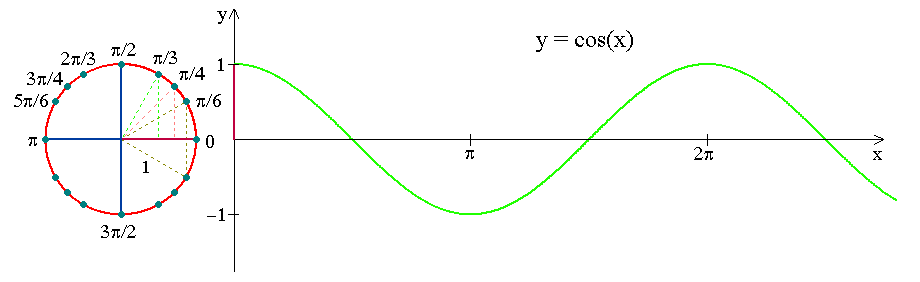

In [ ]:

# Hacemos cyclical feature encoding:
df['sin_month'] = np.sin(df['Month']*(2*np.pi)/12)
df['cos_month'] = np.cos(df['Month']*(2*np.pi)/12)
df['sin_week'] = np.sin(df['Week']*(2*np.pi)/12)
df['cos_week'] = np.cos(df['Week']*(2*np.pi)/12)
df['sin_day'] = np.sin(df['Day']*(2*np.pi)/12)
df['cos_day'] = np.cos(df['Day']*(2*np.pi)/12)
df['sin_WindGustDir'] = np.sin(df['WindGustDir']*(2*np.pi)/12)
df['cos_WindGustDir'] = np.cos(df['WindGustDir']*(2*np.pi)/12)
df.drop(['Month','Week','Day','WindGustDir','WindDir9am','WindDir3pm'],axis=1,inplace=True)

df['MeanTemp'] = (df['MinTemp']+df['MaxTemp'])/2
df['MeanPressure'] = (df['Pressure3pm']+df['Pressure9am'])/2
df['MeanHumidity'] = (df['Humidity3pm']+df['Humidity9am'])/2
df['MeanCloud'] = (df['Cloud3pm']+df['Cloud9am'])/2
df['MeanAlg'] = (df['Alg3pm']+df['Alg9am'])/2
df['DiffTemp'] = (df['MaxTemp']-df['MinTemp'])
df['DiffPressure'] = (df['Pressure3pm']-df['Pressure9am'])
df['DiffHumidity'] = (df['Humidity3pm']-df['Humidity9am'])
df['DiffCloud'] = (df['Cloud3pm']-df['Cloud9am'])
df['DiffAlg'] = (df['Alg3pm']-df['Alg9am'])
#df.drop(['Temp9am','Temp3pm','WindSpeed9am','WindSpeed3pm','Pressure9am','Pressure3pm','Humidity9am','Humidity3pm','Cloud9am','Cloud3pm','Alg9am','Alg3pm'],axis=1,inplace=True)

Vamos a ver como va nuestro dataset:

In [ ]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Alg3pm,Alg9am,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,sin_month,cos_month,sin_week,cos_week,sin_day,cos_day,sin_WindGustDir,cos_WindGustDir,sin_WindDir9am,cos_WindDir9am,sin_WindDir3pm,cos_WindDir3pm
count,116486.000000,116486.000000,115444.000000,64220.000000,59447.000000,108597.000000,115613.000000,114468.000000,116486.000000,116486.000000,115288.000000,114255.000000,104794.000000,104825.000000,70558.000000,67990.000000,116034.000000,114967.000000,116486.000000,116486.000000,1.164860e+05,1.164860e+05,1.164860e+05,1.164860e+05,1.164860e+05,1.164860e+05,1.085410e+05,108541.000000,1.077780e+05,1.077780e+05,1.134090e+05,113409.000000
mean,10.602490,21.062829,2.313944,4.564534,7.217488,39.257576,13.770017,18.475216,0.499518,0.003327,71.535164,54.031438,1018.701760,1016.488933,4.627980,4.625386,15.154759,19.634240,0.235874,0.229410,-4.653090e-02,-1.210435e-01,3.533247e-02,2.030456e-02,1.156050e-01,-4.520935e-02,1.114441e-01,0.191400,1.208033e-01,1.474249e-01,9.999779e-02,0.171891
std,5.422028,5.310365,7.681442,3.453488,3.719137,13.722704,8.956985,8.907320,0.288636,1.000213,17.318107,19.055819,7.149412,6.905130,2.877218,2.725814,5.204413,5.230767,0.424546,0.420455,7.052790e-01,6.969744e-01,7.111432e-01,7.018713e-01,6.950791e-01,7.081420e-01,7.065084e-01,0.672161,7.000210e-01,6.882238e-01,7.150213e-01,0.670229
min,-6.200000,3.600000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000021,-4.124446,1.000000,1.000000,980.500000,977.100000,0.000000,0.000000,-3.700000,-1.700000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000
25%,6.800000,17.100000,0.000000,2.200000,4.400000,30.000000,7.000000,13.000000,0.249150,-0.671613,60.000000,41.000000,1014.300000,1012.200000,1.000000,2.000000,11.500000,15.800000,0.000000,0.000000,-8.660254e-01,-8.660254e-01,-5.000000e-01,-5.000000e-01,-5.000000e-01,-8.660254e-01,-5.000000e-01,-0.500000,-5.000000e-01,-5.000000e-01,-5.000000e-01,-0.500000
50%,10.600000,21.000000,0.000000,4.000000,8.000000,37.000000,13.000000,17.000000,0.498790,0.002115,72.000000,54.000000,1019.000000,1016.600000,6.000000,5.000000,15.200000,19.600000,0.000000,0.000000,-2.449294e-16,-1.836970e-16,3.673940e-16,1.102801e-15,2.388680e-15,-1.836970e-16,1.224647e-16,0.500000,1.224647e-16,1.194340e-15,1.224647e-16,0.500000
75%,14.600000,25.200000,1.000000,6.200000,10.200000,46.000000,19.000000,24.000000,0.749098,0.677876,85.000000,67.000000,1023.400000,1021.000000,7.000000,7.000000,19.000000,23.600000,0.000000,0.000000,5.000000e-01,5.000000e-01,8.660254e-01,8.660254e-01,8.660254e-01,5.000000e-01,8.660254e-01,0.866025,8.660254e-01,8.660254e-01,8.660254e-01,0.866025
max,21.400000,31.400000,371.000000,145.000000,14.500000,135.000000,87.000000,87.000000,0.999997,4.550245,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,30.100000,32.200000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000


Vamos a cruzar los datos con fechas anteriores para tener datos de los días previos:

In [ ]:
# Cogemos las columnas originales
columnas_originales = ['MinTemp', 'MaxTemp', 'Alg3pm', 'Alg9am', 'Humidity9am','Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm','Temp9am', 'Temp3pm', 'RainToday']
for i in range(2):
  # hacemos shift de esas columnas
  df[[col+'_ant'+str(i) for col in columnas_originales]] = df.groupby(['Location'],as_index=True)[columnas_originales].shift(i+1)

Vamos a ver las correlaciones:

In [ ]:
df_corr = df.drop('RainTomorrow',axis=1).corr()
df_corr.style.background_gradient(cmap='coolwarm')

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Alg3pm,Alg9am,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Month,Day,Week
MinTemp,1.000000,0.721888,0.103534,0.481350,0.145999,-0.157710,0.174032,-0.058528,-0.160060,0.174532,0.174767,-0.006446,-0.003228,-0.235915,0.003224,-0.447770,-0.460139,0.112822,0.063579,0.901015,0.710160,0.055916,-0.204728,0.001623,-0.195980
MaxTemp,0.721888,1.000000,-0.072100,0.595249,0.511825,-0.219485,0.061843,-0.230832,-0.182636,0.010644,0.048182,-0.002968,-0.004378,-0.490557,-0.494212,-0.318380,-0.412188,-0.254649,-0.255627,0.868707,0.960428,-0.222637,-0.156956,0.001644,-0.150541
Rainfall,0.103534,-0.072100,1.000000,-0.053320,-0.233421,0.044616,0.127176,0.085398,0.048218,0.086187,0.057626,-0.000695,-0.004677,0.222807,0.253341,-0.165379,-0.123065,0.224464,0.200874,0.010449,-0.078011,0.500118,-0.030846,0.000880,-0.030621
Evaporation,0.481350,0.595249,-0.053320,1.000000,0.411448,-0.078990,0.207272,-0.105968,-0.049273,0.183777,0.138317,-0.003904,0.000556,-0.506539,-0.399094,-0.297182,-0.323509,-0.179083,-0.176502,0.573455,0.596449,-0.170322,-0.004599,0.004984,0.002087
Sunshine,0.145999,0.511825,-0.233421,0.411448,1.000000,-0.077450,0.014275,-0.118115,-0.049292,0.017609,0.068984,0.003079,-0.001835,-0.520658,-0.628246,-0.035180,-0.095153,-0.574744,-0.601081,0.356576,0.533027,-0.331751,0.071330,0.021531,0.070934
WindGustDir,-0.157710,-0.219485,0.044616,-0.078990,-0.077450,1.000000,0.145377,0.394120,0.594846,0.039241,0.102551,-0.000162,-0.000585,0.056578,0.048856,-0.127159,-0.033441,0.068587,0.065379,-0.194028,-0.235224,0.131622,0.049404,-0.003196,0.045673
WindGustSpeed,0.174032,0.061843,0.127176,0.207272,0.014275,0.145377,1.000000,0.036678,0.140895,0.597695,0.680248,0.002273,0.002843,-0.219030,-0.032154,-0.452076,-0.405794,0.060805,0.102736,0.148196,0.032233,0.147680,0.064380,-0.007586,0.065177
WindDir9am,-0.058528,-0.230832,0.085398,-0.105968,-0.118115,0.394120,0.036678,1.000000,0.312549,0.024904,0.073891,0.000106,0.000194,0.131977,0.166945,-0.028058,0.066160,0.123716,0.078202,-0.146741,-0.241129,0.168940,0.018439,-0.004380,0.016449
WindDir3pm,-0.160060,-0.182636,0.048218,-0.049273,-0.049292,0.594846,0.140895,0.312549,1.000000,0.055207,0.094697,0.002533,-0.001206,0.024552,-0.005495,-0.133670,-0.034000,0.051298,0.053825,-0.176653,-0.195760,0.124477,0.035096,-0.000798,0.032752
WindSpeed9am,0.174532,0.010644,0.086187,0.183777,0.017609,0.039241,0.597695,0.024904,0.055207,1.000000,0.517245,0.000726,0.001989,-0.270826,-0.031052,-0.232458,-0.178441,0.042330,0.069458,0.126666,-0.000041,0.101416,0.050985,-0.008884,0.052074


In [ ]:
correlaciones = df.drop('RainTomorrow',axis=1).corr().values
np.fill_diagonal(correlaciones, 0) 

col_correladas = {}
max_corr = 0.9

for i in range(correlaciones.shape[0]):
  for j in range(len(correlaciones[i])):
    if j < i:
      if (correlaciones[i][j] >= max_corr) | (correlaciones[i][j] <= -1*max_corr):
        col_correladas[df_corr.index[i]] = df_corr.columns[j]

col_correladas

{'Pressure3pm': 'Pressure9am',
 'Temp3pm': 'MaxTemp',
 'Temp9am': 'MinTemp',
 'Week': 'Month'}

Vamos a tratar las columnas correlacionadas. 



In [ ]:
df = df.drop(col_correladas.keys(),axis=1)

In [ ]:
# Dividimos en X e y
X, y = df.drop(['RainTomorrow','Humidity3pm'],axis=1), df['RainTomorrow']

# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y)

# Cogemos las filas objetivo en caso de que estuvieran en train
X_ciudades = X_train[(X_train['Date']=="2014-02-05")&(X_train['Location'].isin(['Perth','Sydney']))]
X_test = pd.concat([X_test,X_ciudades])
X_train = X_train[~X_train.index.isin(X_ciudades.index.tolist())]
y_ciudades = y_train[X_ciudades.index.tolist()]
y_test = pd.concat([y_test,y_ciudades])
y_train = y_train.drop(X_ciudades.index.tolist())

# Sacamos las columnas numericas
numeric_features = [val for val in X.drop('Date',axis=1).columns if X[val].dtypes != 'object']

# Le aplicamos un imputer y un scaler
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer()),
    #('imputer', KNNImputer(weights="uniform")),
    #('imputer', IterativeImputer()),
    ('scaler', StandardScaler())
    #('scaler', Normalizer())
])

# Sacamos las columnas categóricas
categorical_features = [val for val in X.drop('Date',axis=1).columns if X[val].dtypes == 'object']

# Le aplicamos un imputer y un onehotencoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    #('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ('ohe', OrdinalEncoder())
    ])

# Agrupamos las transformaciones según sea categórica o numérica
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

from imblearn import pipeline
# Creamos nuestro pipeline completo
clf = pipeline.Pipeline(steps=[('preprocessor', preprocessor),
                              #('sampling',SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=4321)),
                              ('sampling',RandomOverSampler()),
                              #('ridge', SelectFromModel(Ridge())),
                              #('clf', RandomForestClassifier()),
                              #('clf', BaggingClassifier()),
                              ('clf',XGBClassifier()),
                              #('clf',GradientBoostingClassifier())
                     ])

# Sacamos los parámetros que queramos probar:
parameters = {#'preprocessor__num__imputer__strategy':['mean','median'],
              #'preprocessor__num__imputer__n_neighbors':[3],
              #'preprocessor__num__imputer__max_iter':[10,20,30],
              #'lasso__estimator__alpha':[1,10,20],
              #'ridge__estimator__alpha':[0.01,1,10,100],
              #'skb__k':[15,17,20],
              #'etc__estimator__n_estimators':[10,25,50],
              #'clf__splitter':['best','random'],'clf__max_depth':[3,5,7]
              #'clf__max_depth': [17],'clf__n_estimators' : [200]
              #'regressor__n_neighbors':[3,5,7,9,11],'regressor__weights':['uniform','distance']
              #'regressor__iterations':[300,350,400],'regressor__learning_rate':[0.05,0.1,0.15],'regressor__depth':[6,7,8]
              #'regressor__num_leaves':[30,50,70], 'regressor__learning_rate':[0.1,1,10], 'regressor__n_estimators':[100,150,200]
              }
  
# Aplicamos el modelo con un gridsearchcv
clf_mod = GridSearchCV(clf,cv=3,
                       verbose=-1,
                       param_grid=parameters,
                       scoring=['accuracy', 'recall','f1','precision','roc_auc'],
                       refit='roc_auc',
                       return_train_score=True,
                       n_jobs=-1, 
                       error_score='raise')
clf_mod.fit(X_train.drop(['Date'],axis=1),y_train)
print('Final del ajuste')
print("-"*100)
# Para ver la metrica final habrá que quitar logaritmos:
print("Train Accuracy: ",clf_mod.cv_results_['mean_test_accuracy'][0])
print("Train F1: ",clf_mod.cv_results_['mean_test_f1'][0])
print("Train Recall: ",clf_mod.cv_results_['mean_test_recall'][0])
print("Train Precision: ",clf_mod.cv_results_['mean_test_precision'][0])
print("Train ROC-AUC: ",clf_mod.cv_results_['mean_test_roc_auc'][0])
print("-"*100)

Final del ajuste
----------------------------------------------------------------------------------------------------
Train Accuracy:  0.7914782888259287
Train F1:  0.6257326213833792
Train Recall:  0.7775735225218114
Train Precision:  0.5235070437574741
Train ROC-AUC:  0.8720022987310491
----------------------------------------------------------------------------------------------------


In [ ]:
#processed_df = pd.DataFrame(clf_mod.best_estimator_['preprocessor'].transform(X_train.drop('Date',axis=1)).toarray(),columns=numeric_features+clf_mod.best_estimator_['preprocessor'].transformers_[1][1]['ohe'].get_feature_names(categorical_features).tolist())
#idx = clf_mod.best_estimator_['ridge'].get_support()
#columnas = processed_df.columns[idx]
#coefs = clf_mod.best_estimator_['clf'].coef_[0]
#pd.DataFrame({'Variable':columnas,'Coef':coefs})

In [ ]:
y_pred_proba = clf_mod.predict_proba(X_test)
y_pred_proba = [y[1] for y in y_pred_proba]
y_pred = [1 if y>=0.5 else 0 for y in y_pred_proba]
roc_auc_score(y_test,y_pred_proba)
confusion_matrix(y_test,y_pred)

array([[25905,  7191],
       [ 2248,  7316]])

In [ ]:
ciudades = X_test[(X_test['Date']=="2014-02-05")&(X_test['Location'].isin(['Perth','Sydney']))].drop('Date',axis=1)

y_ciudades = clf_mod.predict_proba(ciudades)[:,1]

pd.concat([df[(df['Date']=="2014-02-05")&(df['Location'].isin(['Perth','Sydney']))].reset_index(),pd.DataFrame({'proba':y_ciudades})],axis=1)

,index,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Alg3pm,Alg9am,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,RainToday,RainTomorrow,Month,Day,proba
0,31601,2014-02-05,Sydney,17.5,24.5,3.2,5.2,3.1,10.0,41.0,10.0,10.0,26.0,26.0,0.942749,0.200026,59.0,46.0,1023.9,6.0,7.0,1.0,1.0,2.0,5.0,0.159234
1,119663,2014-02-05,Perth,21.7,32.3,0.0,12.0,12.7,12.0,37.0,12.0,12.0,6.0,17.0,0.265933,2.169603,48.0,51.0,1011.0,3.0,2.0,0.0,0.0,2.0,5.0,0.364757


In [ ]:
plot_importance(cf_mod.best_estimator_['clf'],max_num_features=10)
pyplot.show()